In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
import tensorflow as tf

In [2]:
def display_transform_example(transform,image,mask):
    transform_result = transform(image = image, mask = mask)
    t_image = transform_result['image']
    t_mask = transform_result['mask']
    
    fontsize = 20
    plt.figure(figsize=(20,60))

    plt.subplot(1,3,1)
    plt.imshow(t_image,cmap = 'gray')
    plt.axis('off')
    plt.title('Augumented w/o mask',fontsize=fontsize)

    plt.subplot(1,3,2)
    plt.imshow(t_image,cmap = 'gray')
    plt.imshow(t_mask,alpha=0.1)
    plt.axis('off')
    plt.title('Augumented w mask',fontsize=fontsize)

    plt.subplot(1,3,3)
    plt.imshow(image,cmap = 'gray')
    plt.axis('off')
    plt.title('Original',fontsize=fontsize)

    plt.show()
    
    return t_image, t_mask

In [3]:
DATA_ROOT_PATH = 'D:\Dataset_Collection\Cardiac_Catheterization'

#default
TRAIN_DATA_FOLDER_NAME = 'train'
IMAGE_FOLDER_NAME = 'images'
MASK_FOLDER_NAME = 'masks'

image_paths = list(pathlib.Path(r'D:\Dataset_Collection\Cardiac_Catheterization\train\images').rglob('*.png'))
mask_paths = list(pathlib.Path(r'D:\Dataset_Collection\Cardiac_Catheterization\train\masks').rglob('*.png'))

i = 1
image = (plt.imread(image_paths[i]) * 255).astype(np.uint8)
mask = (plt.imread(mask_paths[i]) * 255).astype(np.uint8)

image[200:210,:] = 0
image[:,200:210] = 0

t_image, t_mask = display_transform_example(transform,image,mask)

NameError: name 'transform' is not defined

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pathlib
import tensorflow as tf
import numpy as np
import random

class TrainDataLoader:
    def __init__(
        self,
        images_root,
        masks_root,
        train_batch_size,
        train_transform,
        train_deterministic,
        validation_ratio,
        validation_batch_size,
        validation_transform,
        validation_deterministic,
        preprocess,
        image_dtype,
        mask_dtype,
        random_state):
        
        images_path = list(pathlib.Path(images_root).rglob('*.png'))
        masks_path = list(pathlib.Path(masks_root).rglob('*.png'))
        
        self.images_path = images_path[:10]
        self.masks_path = masks_path[:10]
        
        self.train_batch_size = train_batch_size
        self.train_transform = train_transform
        self.train_deterministic = train_deterministic
        
        self.validation_ratio = validation_ratio
        self.validation_batch_size = validation_batch_size
        self.validation_transform = validation_transform
        self.validation_deterministic = validation_deterministic
        
        self.preprocess = preprocess
        self.image_dtype = image_dtype
        self.mask_dtype = mask_dtype
        self.random_state = np.random.RandomState(random_state)
        
        self.is_match = False
        
        assert len(images_path) == len(masks_path), f'the number images is : {len(images_path)}, while the number of masks is {len(masks_path)}, and they do not match'
        for i, (image_path, mask_path) in enumerate(zip(images_path,masks_path)):
            assert image_path.name == mask_path.name, f'pair {i}, image: {image_path.name} and mask: {mask_path.name} do not match'
            
        self.is_match = True
                
    def get_dataset(self):
        if not self.is_match:
            raise Exception('images and masks do not match')
        
        train_images_path, validation_images_path, train_masks_path, validation_masks_path = train_test_split(
            self.images_path,
            self.masks_path,
            test_size = self.validation_ratio,
            random_state=self.random_state)
        
        train_dataset = Dataset(
            images_path=train_images_path,
            masks_path=train_masks_path,
            batch_size=self.train_batch_size,
            shuffle=True,
            transform=self.train_transform,
            preprocess=self.preprocess,
            image_dtype=self.image_dtype,
            mask_dtype=self.mask_dtype,
            deterministic=self.train_deterministic)
        
        validation_dataset = Dataset(
            images_path=validation_images_path,
            masks_path=validation_masks_path,
            batch_size=self.validation_batch_size,
            shuffle=False,
            transform=self.validation_transform,
            preprocess=self.preprocess,
            image_dtype=self.image_dtype,
            mask_dtype=self.mask_dtype,
            deterministic=self.validation_deterministic)
        
        return train_dataset, validation_dataset

    
class Dataset:
    def __init__(self, images_path, masks_path, batch_size, shuffle, transform, preprocess, image_dtype='float32', mask_dtype='float32', deterministic=True):
        self.images_path = [p.as_posix() for p in images_path]
        self.masks_path = [p.as_posix() for p in masks_path]
        self.batch_size = batch_size
        self.need_shuffle = shuffle
        self.transform = transform
        self.preprocess = preprocess
        if isinstance(image_dtype,tf.DType):
            self.image_dtype = image_dtype
        else:
            self.image_dtype = getattr(tf,image_dtype)
        if isinstance(mask_dtype,tf.DType):
            self.mask_dtype = mask_dtype
        else:
            self.mask_dtype = getattr(tf,mask_dtype)
        self.deterministic = deterministic
    
    def __call__(self,epoch):
        def transform_func(image_path,mask_path):
            random.seed(6)
            
            image = tf.io.decode_png(tf.io.read_file(image_path)).numpy() 
            mask = tf.io.decode_png(tf.io.read_file(mask_path)).numpy()
            
            transform = A.Compose([self.transform(epoch),self.preprocess],p=1)
            transform_pair = transform(image=image,mask=mask)
            
            image = tf.convert_to_tensor(transform_pair['image'],dtype=tf.uint8)
            mask = tf.convert_to_tensor(transform_pair['mask'],dtype=tf.uint8)
            
            image = tf.image.convert_image_dtype(image, self.image_dtype)
            mask = tf.image.convert_image_dtype(mask, self.mask_dtype)
            return image_path, image, mask
        
        tf_transform_func = lambda image, mask : tf.py_function(func=transform_func, inp=[image,mask], Tout=[tf.string, self.image_dtype,self.mask_dtype])
        
        tf_dataset = tf.data.Dataset.from_tensor_slices((self.images_path,self.masks_path))
        if self.need_shuffle:
            tf_dataset = tf_dataset.shuffle(1000)
        tf_dataset = tf_dataset.map(tf_transform_func, num_parallel_calls=tf.data.AUTOTUNE, deterministic=self.deterministic)
        #tf_dataset = tf_dataset.batch(self.batch_size, num_parallel_calls=tf.data.AUTOTUNE, deterministic=self.deterministic)
        tf_dataset = tf_dataset.prefetch(tf.data.AUTOTUNE)
        return tf_dataset

    
class Data:
    def __init__(self, images_path, transform, preprocess, ):
        if transform is None:
            transform = A.NoOp()
        
        self.transform = A.Compose([transform,preprocess],p=1)
        pass

In [2]:
from Configuration import Editor

import Transform.Schedule

with Editor('Config') as Config:
    Config.Random.Seed = 4
    #prepare dataset before training
    
    Config.Dataset.ImagesRootPath = r'D:\Dataset_Collection\Cardiac_Catheterization\train\images'
    Config.Dataset.MasksRootPath = r'D:\Dataset_Collection\Cardiac_Catheterization\train\masks'
    
    Config.Dataset.Output.ImageDtype = 'float32'
    Config.Dataset.Output.MaskDtype = 'float32'
    
    Config.Dataset.Preprocess.Version = 'v1'
    #train dataset
    Config.Dataset.Train.BatchSize = 4
    Config.Dataset.Train.Deterministic = True
    Config.Dataset.Train.Transform.Combination.Version = 'v1'
    Config.Dataset.Train.Transform.Schedule = 0.8
    Config.Dataset.Train.Transform.Combination.Components = 'default'
    Config.Dataset.Train.Transform.Combination.Params = 'default'
    Config.Dataset.Train.Transform.Combination.Schedules = 'default'
    #validation dataset
    Config.Dataset.Validation.BatchSize = 4
    Config.Dataset.Validation.Ratio = 3
    Config.Dataset.Validation.Deterministic = True
    Config.Dataset.Validation.Transform.Combination.Version = 'v1'
    Config.Dataset.Validation.Transform.Schedule = 0.8
    Config.Dataset.Validation.Transform.Combination.Components = 'default'
    Config.Dataset.Validation.Transform.Combination.Params = 'default'
    Config.Dataset.Validation.Transform.Combination.Schedules = 'default'
    
    
#     Config.Model.Class = object
#     Config.Model.Param = {}
    
    Config.Training.Attempts = 2
    Config.Training.Epochs = 3
    Config.Training.GradientAccumulation = 1
    
#     Config.Training.Loss.Class = object
#     Config.Training.Loss.Param = {}
    
#     Config.Training.Schedule.Class = object
#     Config.Training.Schedule.Param = {}
    
#     Config.Training.Optimizer.Class = tf
#     Config.Training.Optimizer.Param = {'lr':0.0005}
    
    
#     Config.Callback.ModelSavePath = ''
#     Config.Callback.WeightsSavePath = ''
    
#     Config.Logging.ProjectName = 'model_1 demo'
#     Config.Logging.ModelName = 'model_1'
#     Config.Logging.TrialCount = 2
#     Config.Logging.Comment = 'change Optimizer, Loss function'
#     Config.Logging.Purpose = ''
#     Config.Logging.Note = 'the'
    

===============attempt 0==================
==========epoch 0=============
=====Train=====
b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_49.png'


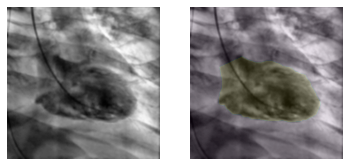

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_54.png'


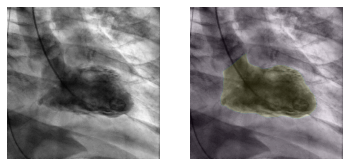

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_53.png'


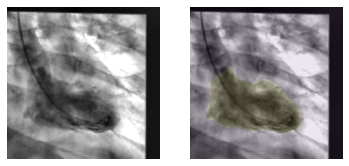

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_47.png'


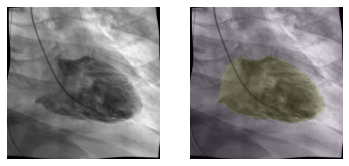

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_56.png'


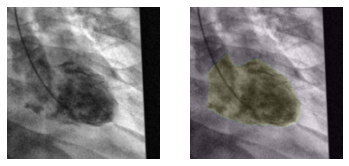

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_52.png'


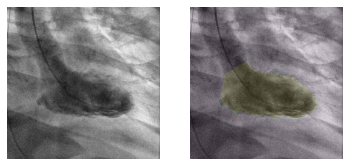

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_48.png'


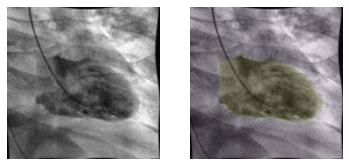

=====Validation=====
b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_50.png'


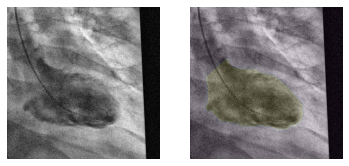

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_55.png'


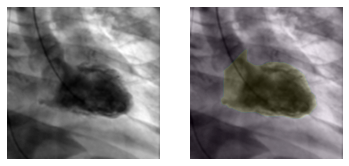

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_51.png'


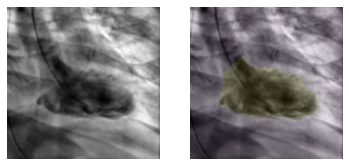

==========epoch 1=============
=====Train=====
b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_56.png'


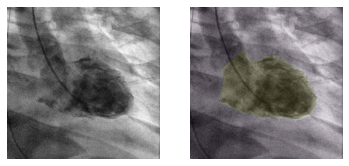

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_48.png'


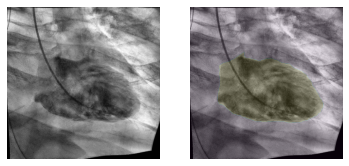

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_53.png'


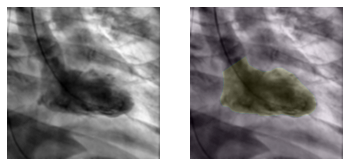

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_49.png'


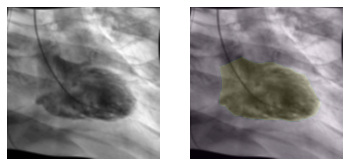

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_47.png'


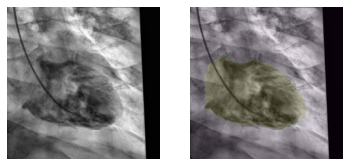

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_54.png'


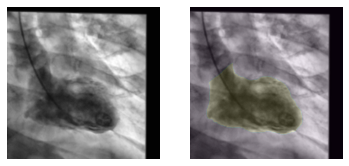

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_52.png'


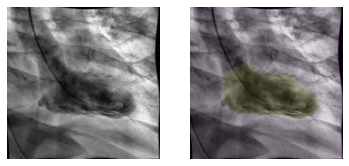

=====Validation=====
b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_50.png'


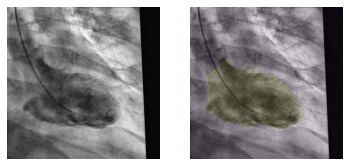

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_55.png'


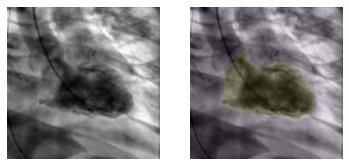

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_51.png'


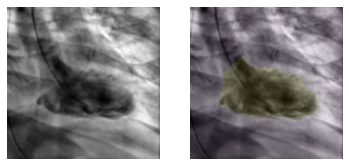

==========epoch 2=============
=====Train=====
b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_56.png'


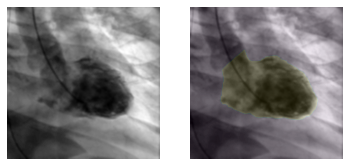

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_48.png'


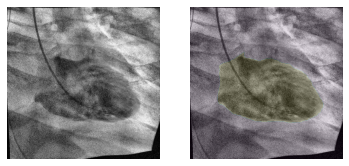

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_53.png'


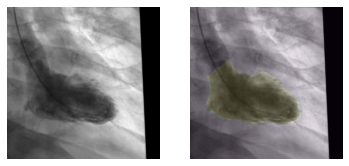

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_54.png'


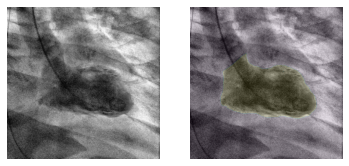

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_47.png'


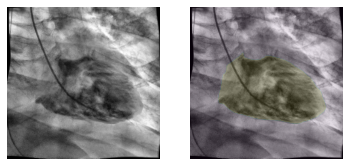

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_52.png'


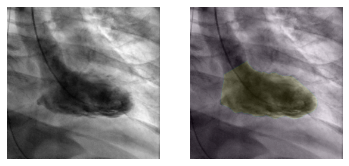

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_49.png'


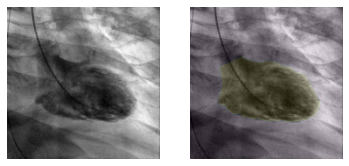

=====Validation=====
b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_50.png'


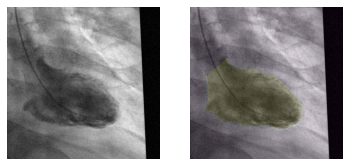

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_55.png'


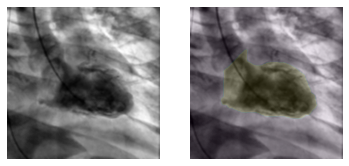

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_51.png'


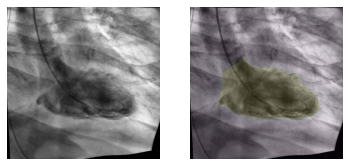

===============attempt 1==================
==========epoch 0=============
=====Train=====
b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_55.png'


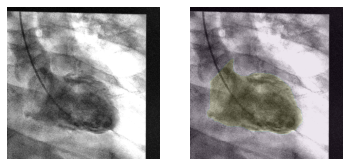

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_54.png'


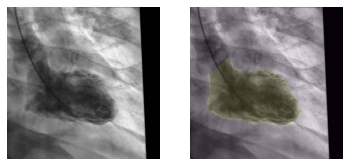

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_48.png'


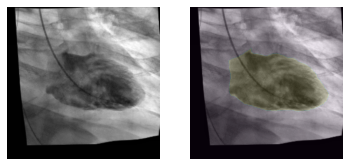

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_51.png'


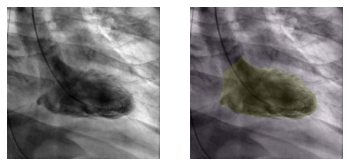

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_47.png'


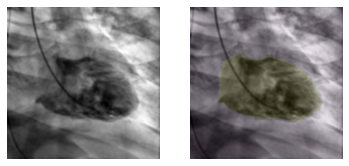

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_49.png'


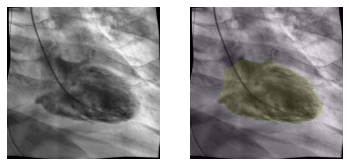

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_56.png'


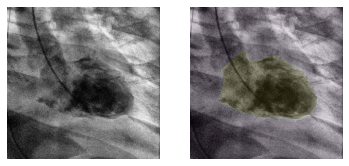

=====Validation=====
b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_53.png'


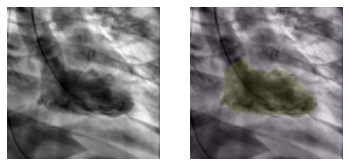

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_50.png'


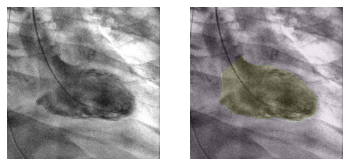

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_52.png'


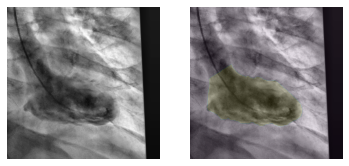

==========epoch 1=============
=====Train=====
b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_49.png'


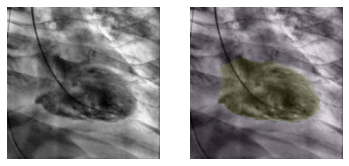

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_56.png'


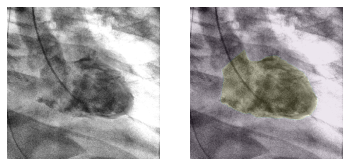

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_54.png'


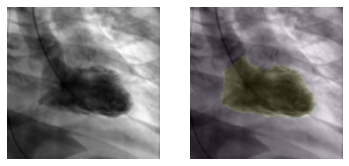

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_47.png'


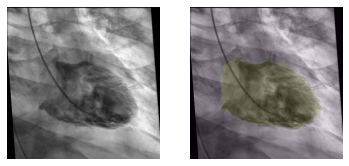

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_48.png'


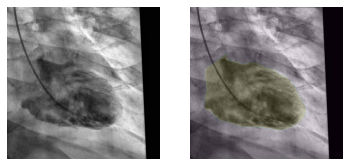

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_51.png'


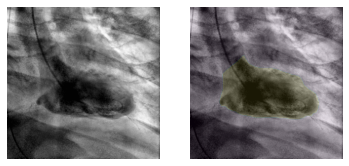

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_55.png'


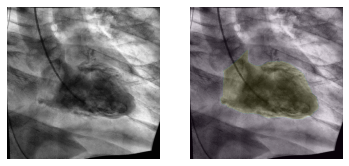

=====Validation=====
b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_53.png'


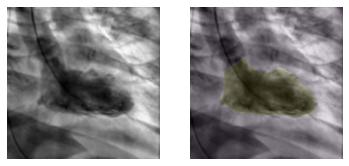

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_50.png'


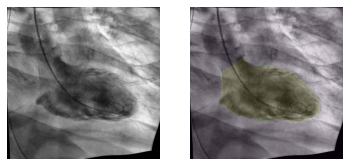

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_52.png'


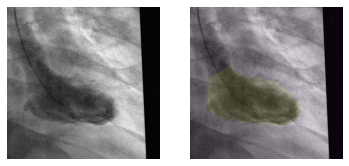

==========epoch 2=============
=====Train=====
b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_54.png'


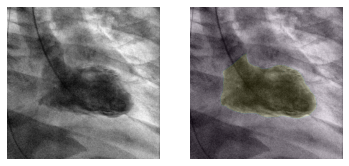

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_49.png'


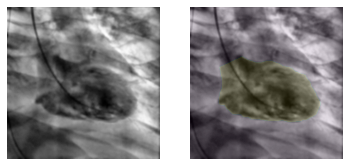

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_48.png'


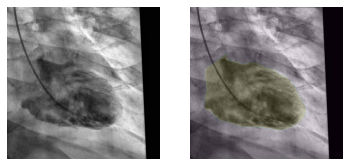

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_47.png'


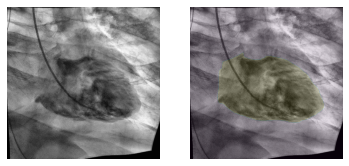

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_56.png'


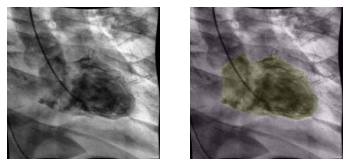

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_55.png'


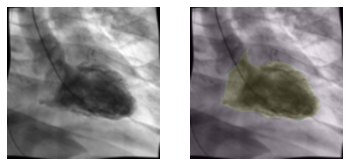

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_51.png'


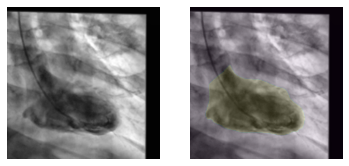

=====Validation=====
b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_53.png'


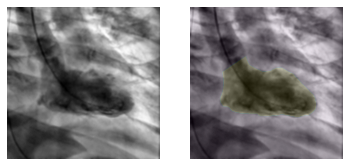

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_50.png'


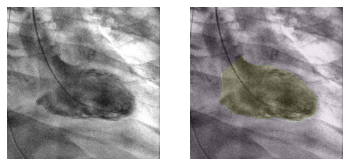

b'D:/Dataset_Collection/Cardiac_Catheterization/train/images/0655 ant hypo/0655[0]_52.png'


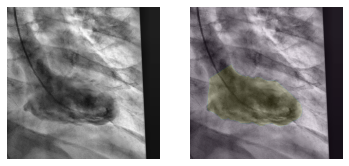

In [3]:
import numpy as np

# from Dataset import TrainDataLoader
import Configuration

import Transform.Preprocess
import Transform.Combinations
import Transform.Schedule

Config = Configuration.Config

np.random.seed(Config.Random.Seed)
tf.random.set_seed(Config.Random.Seed)

train_transform_creater = getattr(Transform.Combinations, Config.Dataset.Train.Transform.Combination.Version)
train_transform_creater = train_transform_creater(
    Config.Dataset.Train.Transform.Schedule,
    Config.Dataset.Train.Transform.Combination.Components,
    Config.Dataset.Train.Transform.Combination.Params,
    Config.Dataset.Train.Transform.Combination.Schedules)

validation_transform_creater = getattr(Transform.Combinations, Config.Dataset.Validation.Transform.Combination.Version)
validation_transform_creater = validation_transform_creater(
    Config.Dataset.Validation.Transform.Schedule,
    Config.Dataset.Validation.Transform.Combination.Components,
    Config.Dataset.Validation.Transform.Combination.Params,
    Config.Dataset.Validation.Transform.Combination.Schedules)

preprocess = getattr(Transform.Preprocess,Config.Dataset.Preprocess.Version)

dataloader = TrainDataLoader(
    images_root = Config.Dataset.ImagesRootPath,
    masks_root = Config.Dataset.MasksRootPath,
    train_batch_size = Config.Dataset.Train.BatchSize,
    train_transform = train_transform_creater,
    train_deterministic = Config.Dataset.Train.Deterministic,
    validation_ratio = Config.Dataset.Validation.Ratio,
    validation_batch_size = Config.Dataset.Validation.BatchSize,
    validation_transform = validation_transform_creater,
    validation_deterministic = Config.Dataset.Validation.Deterministic,
    preprocess = preprocess,
    image_dtype = Config.Dataset.Output.ImageDtype,
    mask_dtype = Config.Dataset.Output.MaskDtype,
    random_state = Config.Random.Seed)

for attempt in range(Config.Training.Attempts):
    train_dataset, validation_dataset = dataloader.get_dataset()
    print(f'===============attempt {attempt}==================')
    
#     model = build_new_model(seed)
    for epoch in range(Config.Training.Epochs):
        print(f'==========epoch {epoch}=============')
        train_transform = train_transform_creater(epoch)
        validation_transform = validation_transform_creater(epoch)
        
        print('=====Train=====')
        for batch_train_data in train_dataset(epoch):
            image_path,image,mask = batch_train_data
            print(image_path.numpy())
            plt.figure()
            plt.subplot(1,2,1)
            plt.imshow(image,cmap = 'gray')
            plt.axis('off')
            plt.subplot(1,2,2)
            plt.imshow(image,cmap = 'gray')
            plt.imshow(mask,alpha=0.1)
            plt.axis('off')
            plt.show()
            
        print('=====Validation=====')
        for batch_validation_data in validation_dataset(epoch):
            image_path,image,mask = batch_validation_data
            print(image_path.numpy())
            plt.figure()
            plt.subplot(1,2,1)
            plt.imshow(image,cmap = 'gray')
            plt.axis('off')
            plt.subplot(1,2,2)
            plt.imshow(image,cmap = 'gray')
            plt.imshow(mask,alpha=0.1)
            plt.axis('off')
            plt.show()